In [1]:
# Librairies
import os
import sys
code_path = os.path.split(os.getcwd())[0]
sys.path.append(code_path)
import numpy as np
from scipy.sparse import load_npz
import seaborn as sns
import pandas as pd
from setting import *
from loader import *
from graphs import *
from utils import *
from plots_and_stats import *
from clustering import *
from XAI_method import *

/projects/GraphNEx/anaconda3/envs/GraphNEx/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
# Arguments
name = "ttg-all"
normalize = True # False
model_name = 'MLP'
exp = 1
XAI_method = "Integrated_Gradients" # "Expected_Gradients"
set_name = 'train'

In [15]:
# Path
save_path = get_save_path(name, code_path)
save_path = os.path.join(save_path, model_name, f"exp_{exp}", XAI_method)
data_path = get_data_path(name)
create_new_folder(os.path.join(save_path, "figures", set_name))

In [16]:
## To load results from another folder
# save_path = '/projects/GraphNEx/xai/XAI_for_genomics/Simulation/Results/SimuA/LR/exp_1/Integrated_Gradients'
# create_new_folder(os.path.join(save_path, "figures", set_name))
# create_new_folder('/projects/GraphNEx/xai/XAI_for_genomics/Simulation/Results/SimuA/LR/exp_1/graph')

In [17]:
# Load explanations
X, y_pred, y, class_name, feat_name, baseline, baseline_pred = load_attributions(XAI_method, save_path, set_name=set_name)
if normalize:
    X = transform_data(X, transform='divide_by_norm')
# Only correctly classified examples are considered
indices = np.argwhere(y_pred == y).reshape(-1)
X = X[indices]
y = y[indices]

Baseline


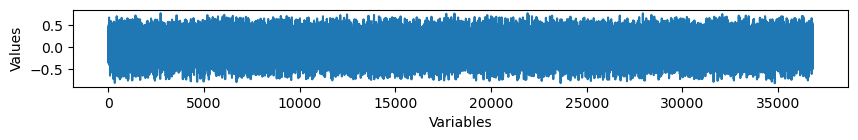

Output of the MLP: [0.9999957084655762, 4.3291383917676285e-06]


In [18]:
# Baseline
print("Baseline")
save_name = os.path.join(save_path, "figures", "baseline")
plot_random_signals(baseline, [0], n_sample_per_class=1, n_variable=baseline.shape[1], save_name=save_name, legend=False)
print(f"Output of the {model_name}: {baseline_pred}")

# Describe data

In [7]:
n_class = len(class_name)
print(f"Number of classes: {n_class}\nNumber of variables: {X.shape[1]}\nNumber of samples: {X.shape[0]}")
for c in range(n_class):
    print(f"    Class {c} - {np.sum(y==c)}")

Number of classes: 2
Number of variables: 58274
Number of samples: 654
    Class 0 - 654
    Class 1 - 0


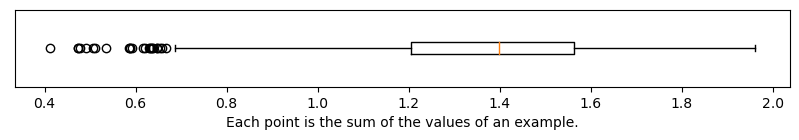

In [71]:
plt.figure(figsize=(10, 1))
plt.boxplot(np.round(np.sum(X, axis=1), 5), vert=False)
plt.yticks([])
plt.xlabel("Each point is the sum of the values of an example.")
plt.show()

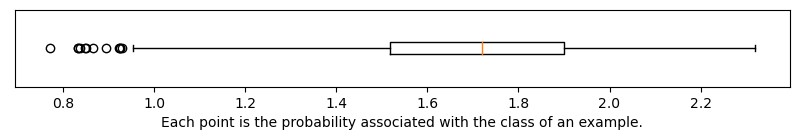

In [72]:
plt.figure(figsize=(10, 1))
plt.boxplot(np.round(np.sum(X, axis=1), 5) + np.array(baseline_pred)[y], vert=False)
plt.yticks([])
plt.xlabel("Each point is the probability associated with the class of an example.")
plt.show()

Attributions averaged per class without std


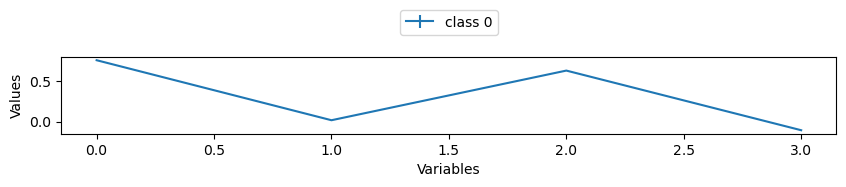

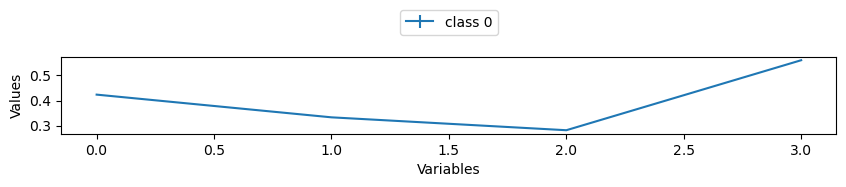

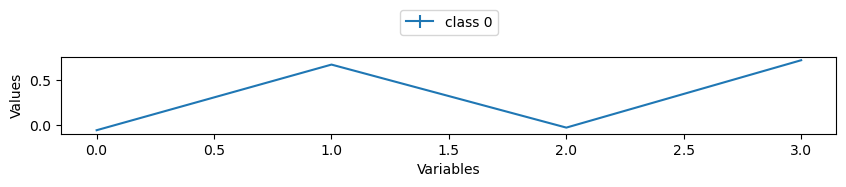

In [73]:
print("Attributions averaged per class without std")
save_name = os.path.join(save_path, "figures", set_name, "average_attributions_without_std")
for c in range(n_class):
    plot_average_signals(np.mean(X[y==c, :], axis=0).reshape(1, -1), np.array([0]), n_variable=X.shape[1], save_name=save_name)

Attributions averaged per class with std


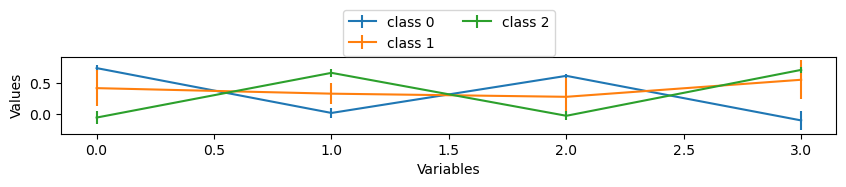

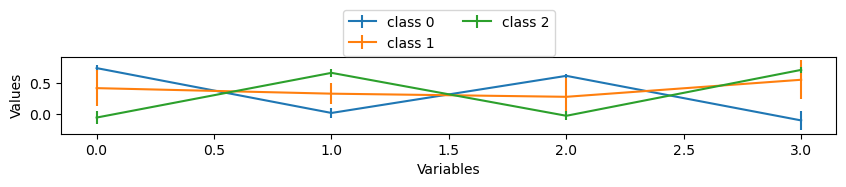

In [74]:
print("Attributions averaged per class with std")
save_name = os.path.join(save_path, "figures", set_name, f"average_attributions")
plot_average_signals(X, y, n_variable=X.shape[1], save_name=save_name)
plot_average_signals(X, y, n_variable=40, save_name=save_name)

Random attributions


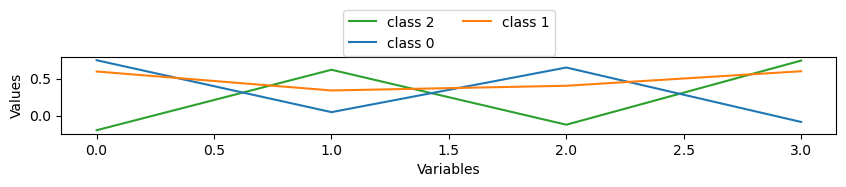

In [75]:
print("Random attributions")
save_name = os.path.join(save_path, "figures", set_name, f"random_attributions")
plot_random_signals(X, y, n_sample_per_class=1, n_variable=60, save_name=save_name)

# Analysis data

### Correlation matrices

In [76]:
method = 'pearson_correlation'
min_value = None

Matrix: pearson_correlation


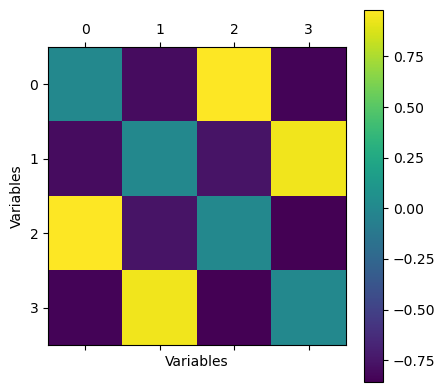

In [77]:
# Between variables
save_name = os.path.join(save_path, "figures", set_name, f"{method}_variables")
print(f"Matrix: {method}")
A = load_npz(os.path.join(save_path, 'graph', f'{set_name}_{method}_{min_value}_variables.npz'))
A = A.toarray()
plot_matrix(A, "Variables", "Variables", save_name)

In [78]:
A = X[np.argwhere(y==0).reshape(-1)]
A.shape

(202, 4)

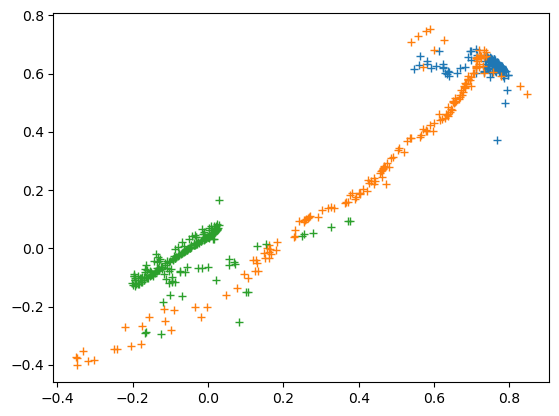

In [111]:
plt.plot(X[y==0, 0], X[y==0, 2], '+')
plt.plot(X[y==1, 0], X[y==1, 2], '+')
plt.plot(X[y==2, 0], X[y==2, 2], '+')
plt.show()

In [80]:
np.corrcoef(A[:, 0], A[:, 2])

array([[ 1.        , -0.19948162],
       [-0.19948162,  1.        ]])

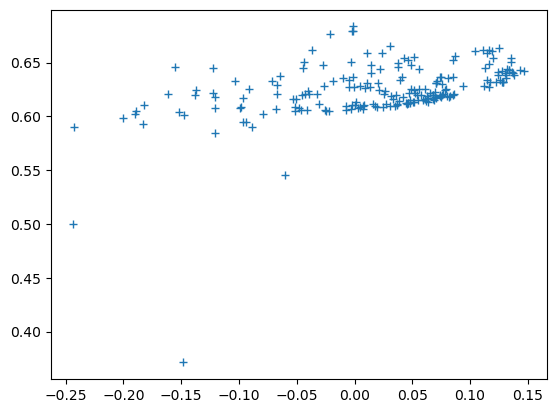

In [81]:
plt.plot(A[:, 1], A[:, 2], '+')
plt.show()

In [82]:
np.corrcoef(A[:, 1], A[:, 2])

array([[1.        , 0.45183588],
       [0.45183588, 1.        ]])

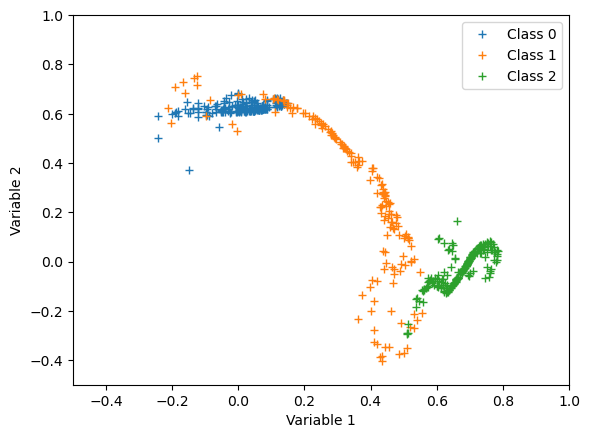

In [83]:
plt.plot(X[y==0, 1], X[y==0, 2], '+', label="Class 0")
plt.plot(X[y==1, 1], X[y==1, 2], '+', label="Class 1")
plt.plot(X[y==2, 1], X[y==2, 2], '+', label="Class 2")
plt.xlabel("Variable 1")
plt.ylabel("Variable 2")
plt.xlim(-0.5, 1)
plt.ylim(-0.5, 1)
plt.legend()
plt.show()

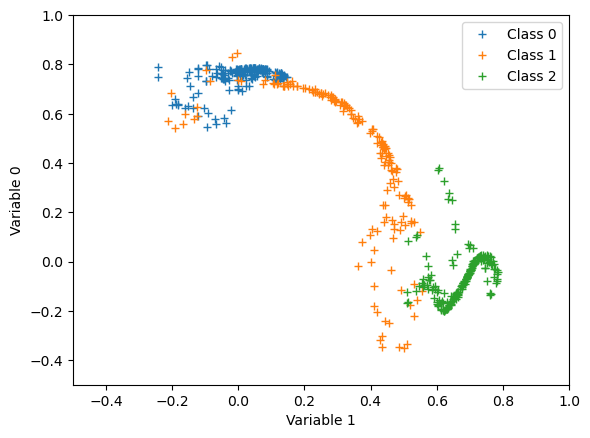

In [84]:
plt.plot(X[y==0, 1], X[y==0, 0], '+', label="Class 0")
plt.plot(X[y==1, 1], X[y==1, 0], '+', label="Class 1")
plt.plot(X[y==2, 1], X[y==2, 0], '+', label="Class 2")
plt.xlabel("Variable 1")
plt.ylabel("Variable 0")
plt.xlim(-0.5, 1)
plt.ylim(-0.5, 1)
plt.legend()
plt.show()

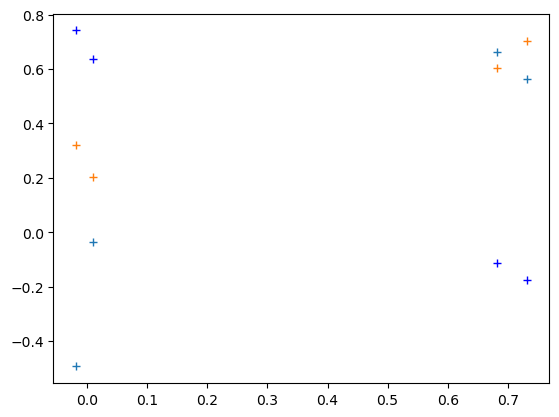

In [85]:
colors = ['r', 'b', 'g']
plt.plot(X[0, :], X[1, :], '+', color=colors[y[0]])
plt.plot(X[0, :], X[2, :], '+')
plt.plot(X[0, :], X[3, :], '+')
plt.show()

Matrix: pearson_correlation


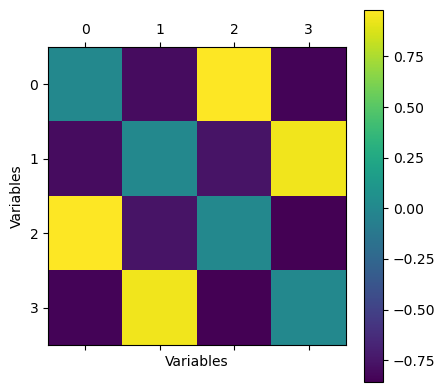

In [86]:
# Between variables
save_name = os.path.join(save_path, "figures", set_name, f"{method}_variables")
print(f"Matrix: {method}")
A = load_npz(os.path.join(save_path, 'graph', f'{set_name}_{method}_{min_value}_variables.npz'))
A = A.toarray()
plot_matrix(A[:, :30][:30, :], "Variables", "Variables", save_name)

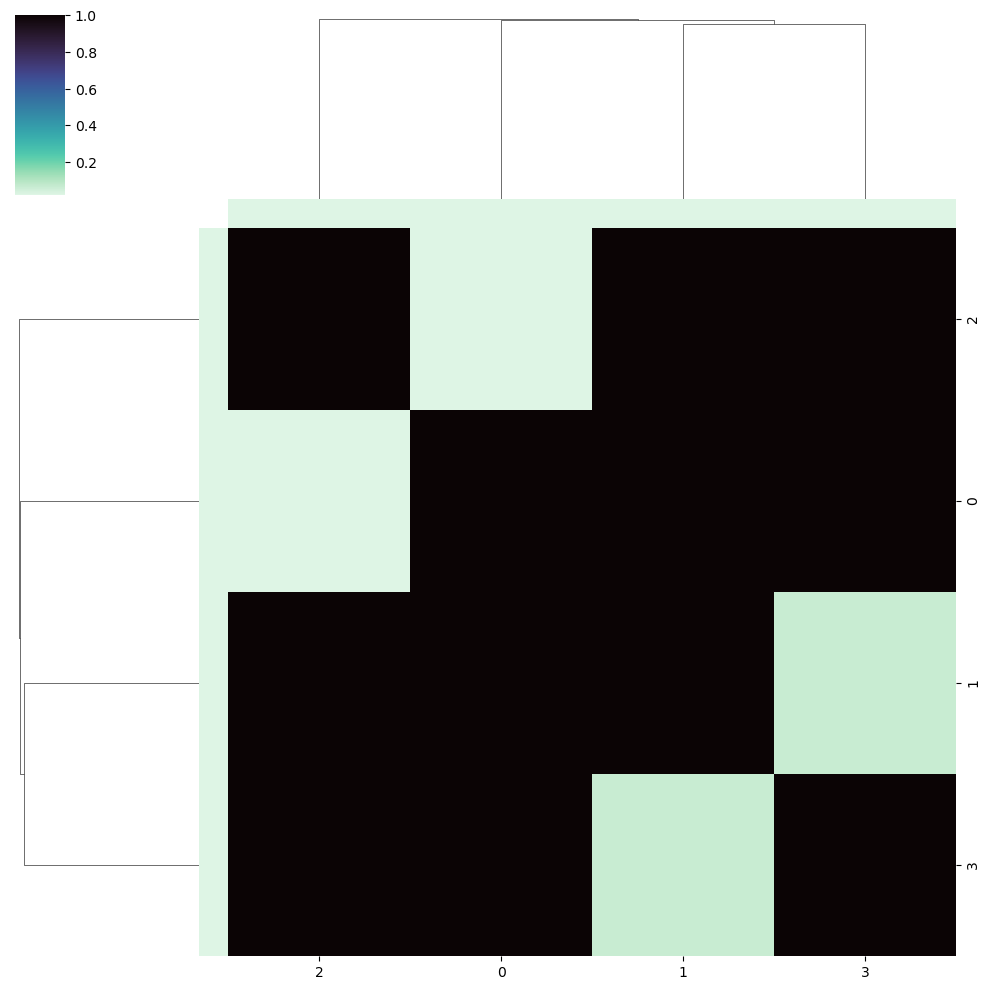

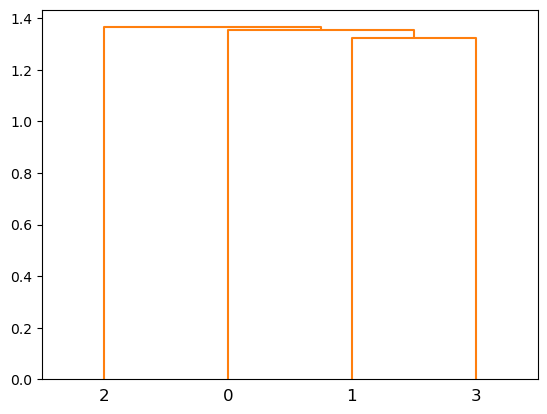

In [87]:
assert np.max(A) <= 1
dist = 1 - (A > 0) * 1. * A
save_name = os.path.join(save_path, "figures", set_name, "cluster_variables")
clusters, colors = cluster_nodes(dist, np.zeros(dist.shape), cut_dendogram=2, vmin=np.min(dist), vmax=np.max(dist), save_path=save_name)

Matrix: pearson_correlation


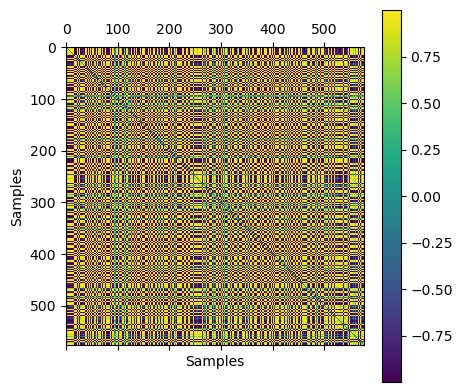

In [88]:
# Between samples
save_name = os.path.join(save_path, "figures", set_name, f"{method}_samples")
print(f"Matrix: {method}")
A = load_npz(os.path.join(save_path, 'graph', f'{set_name}_{method}_{min_value}_samples.npz'))
A = A.toarray()
plot_matrix(A, "Samples", "Samples", save_name)

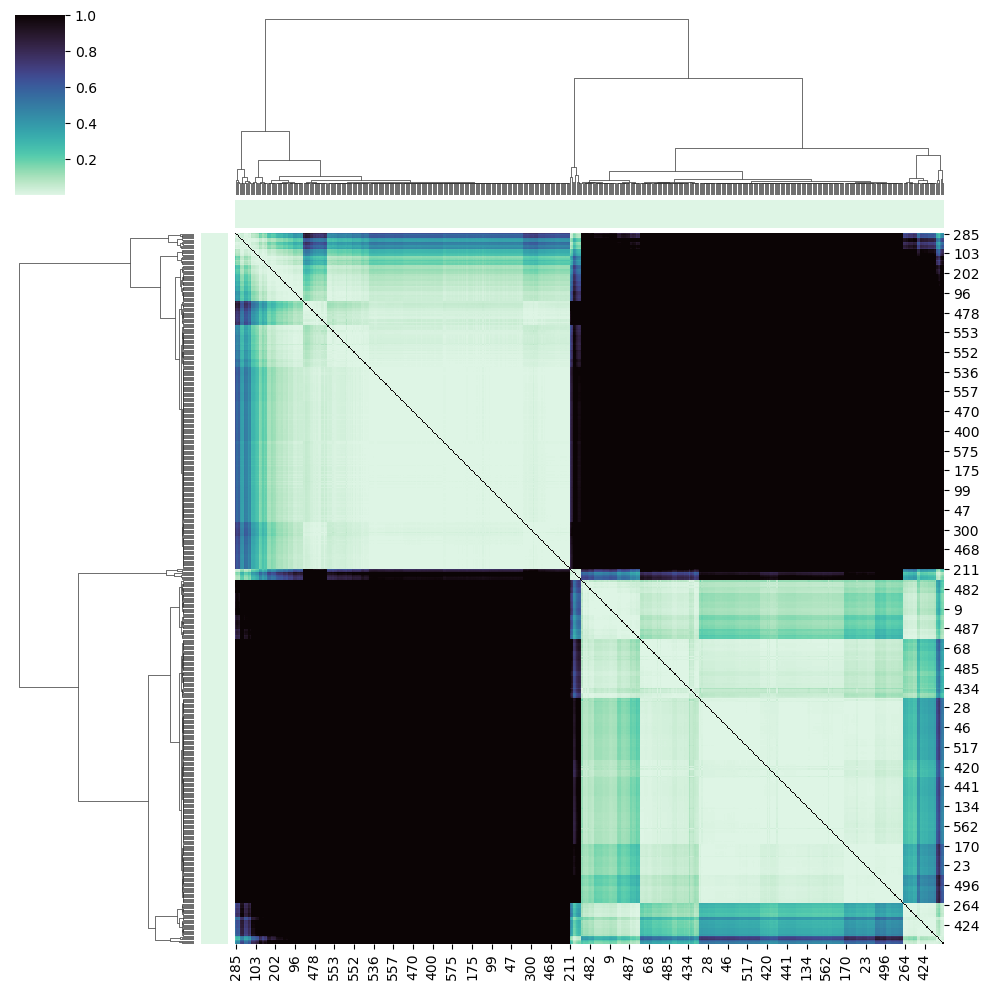

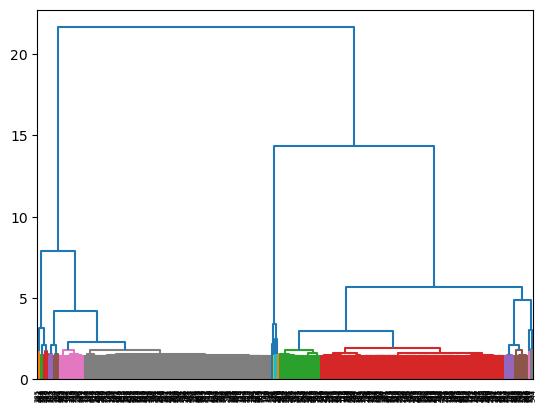

In [89]:
assert np.max(A) <= 1
dist = 1 - (A > 0) * 1. * A
save_name = os.path.join(save_path, "figures", set_name, "cluster_samples")
clusters, colors = cluster_nodes(dist, np.zeros(dist.shape), cut_dendogram=2, vmin=np.min(dist), vmax=np.max(dist), save_path=save_name)

### Dimensionality reduction and 2D visualisation

#### Variables

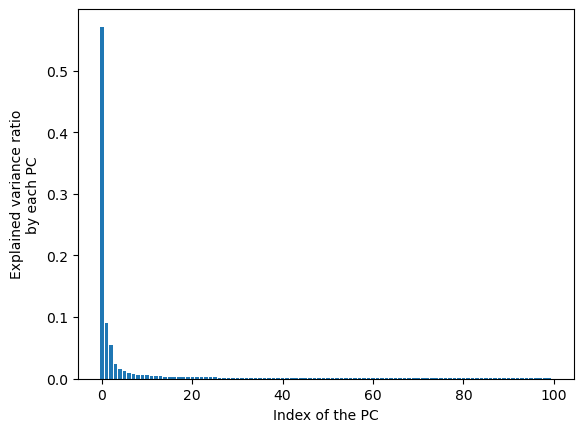

The total variance explained by the first 654 PC is 1.0.


In [8]:
_, _ = do_PCA(X.T)

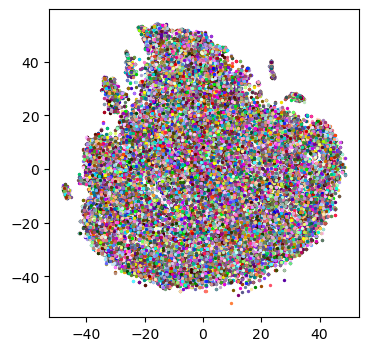

In [9]:
# T-SNE
save_name = os.path.join(save_path, "figures", set_name, "tSNE_variables")
Xr = do_TSNE(X.T, perplexity=30)
do_scatterplot_2D(Xr, np.arange(X.shape[1]).reshape(-1, 1), np.arange(X.shape[1]), xlabel=None, ylabel=None, dim1=0, dim2=1, legend=False, size=2, save_name=save_name)

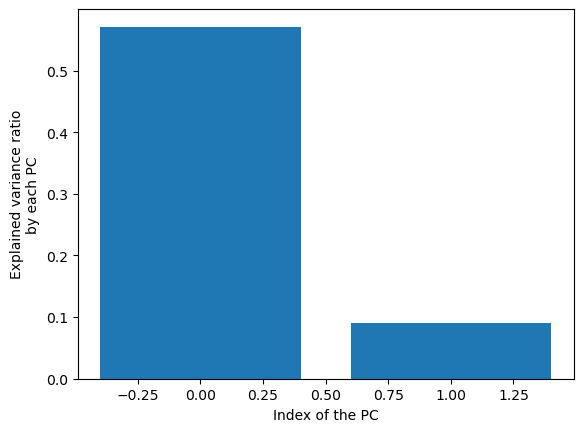

The total variance explained by the first 2 PC is 0.6600000262260437.


KeyboardInterrupt: 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f4a7e99d320> (for post_execute):



KeyboardInterrupt



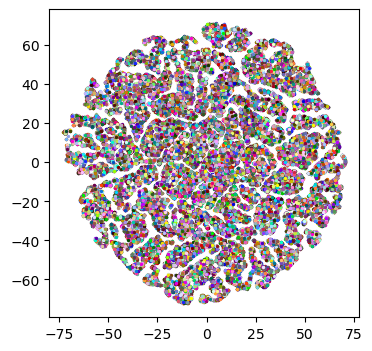

In [10]:
# PCA + T-SNE
n_dim = 2
Xt, alg = do_PCA(X.T, n_dim)
save_name = os.path.join(save_path, "figures", set_name, f"tSNE_PCA_{n_dim}_variables")
Xr = do_TSNE(Xt, perplexity=30)
do_scatterplot_2D(Xr, np.arange(X.shape[1]).reshape(-1, 1), np.arange(X.shape[1]), xlabel=None, ylabel=None, dim1=0, dim2=1, legend=False, size=2, save_name=save_name)

#### Samples

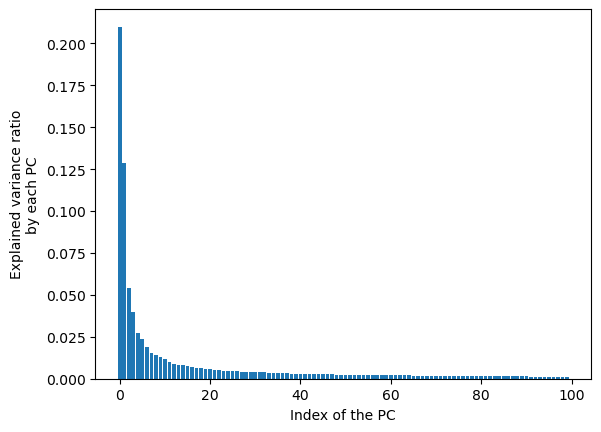

The total variance explained by the first 654 PC is 1.0.


In [11]:
_, _ = do_PCA(X)

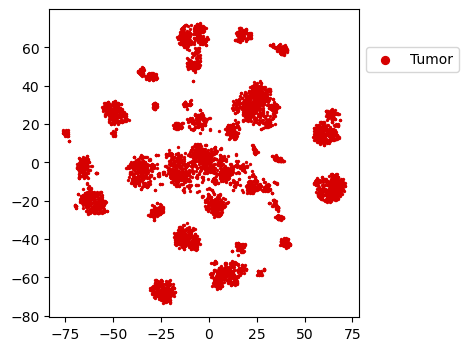

In [19]:
# T-SNE
save_name = os.path.join(save_path, "figures", set_name, "tSNE_samples")
Xr = do_TSNE(X, perplexity=30)
class_name = ["Normal", "Tumor"]
do_scatterplot_2D(Xr, y.reshape(-1, 1), class_name, xlabel=None, ylabel=None, dim1=0, dim2=1, legend=True, size=2, save_name=save_name)

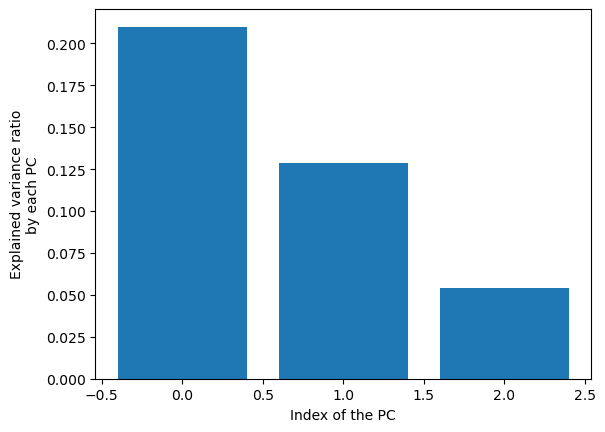

The total variance explained by the first 3 PC is 0.38999998569488525.


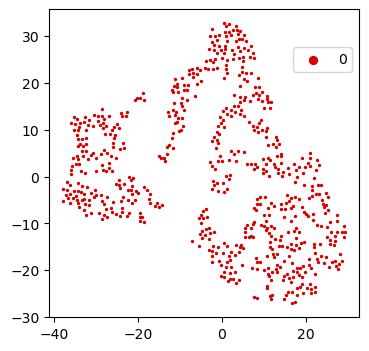

In [13]:
# PCA + T-SNE
n_dim = 3
Xt, alg = do_PCA(X, n_dim)
save_name = os.path.join(save_path, "figures", set_name, f"tSNE_PCA_{n_dim}_samples")
Xr = do_TSNE(Xt, perplexity=30)
do_scatterplot_2D(Xr, y.reshape(-1, 1), class_name, xlabel=None, ylabel=None, dim1=0, dim2=1, legend=True, size=2, save_name=save_name)

### Histograms & Boxplots

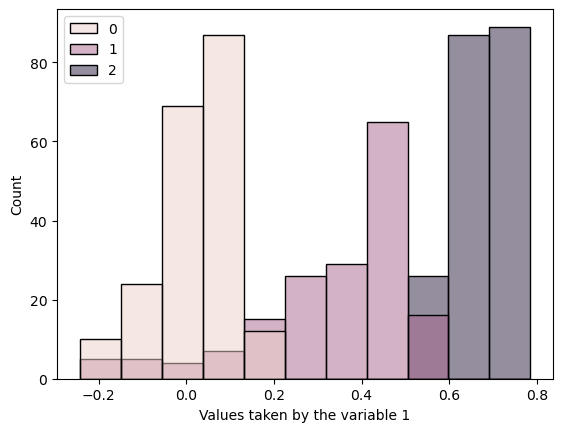

In [96]:
data = pd.DataFrame(X)
v = 1
sns.histplot(data=data, x=v, hue=y)
plt.xlabel(f"Values taken by the variable {v}")
plt.savefig(os.path.join(save_path, "figures", set_name, f"histogram_{v}_variable"), bbox_inches='tight')
plt.show()

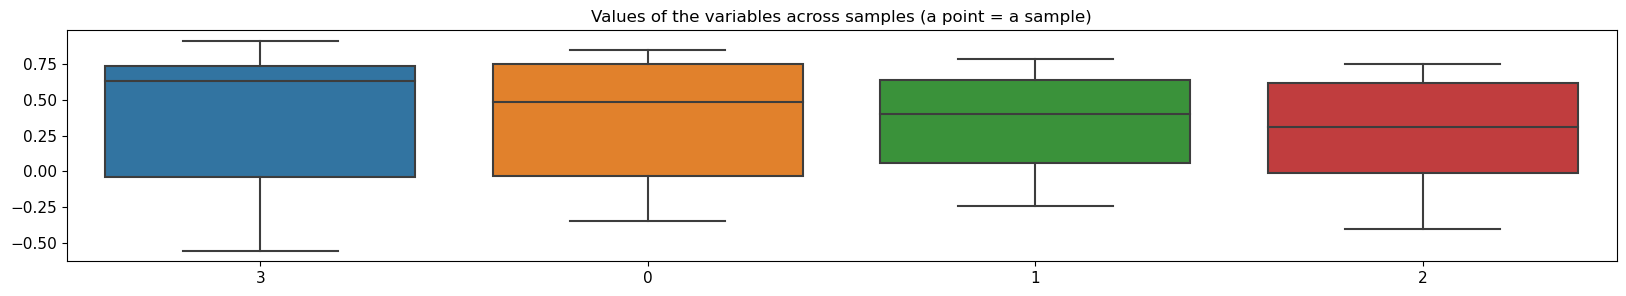

In [97]:
plot_variables_in_boxes(X, feat_name, n_feat=60, method='mean_max', save_name=os.path.join(save_path, "figures", set_name, f"boxplot_variable"))

### Summary plot

In [98]:
plot_path = os.path.join(os.path.split(os.path.split(os.getcwd())[0])[0], "path_explain_master")
sys.path.append(plot_path)
from path_explain import summary_plot, scatter_plot

In [99]:
# Baseline
base_class, studied_class = get_XAI_hyperparameters(name, n_class)

In [100]:
device = "cpu"

# Dataset
train_loader, test_loader, n_class, n_feat, class_name, feat_name, transform, n_sample = load_dataloader(data_path, 
                                                                                                         name, 
                                                                                                         device)

# Set
if set_name == 'train':
    loader = train_loader
elif set_name == 'test':
    loader = test_loader

### Error with the size of data
n_sample = 0
for d, l in loader:
    if XAI_method == "Expected_Gradients":
        n_sample += l.shape[0]
    else:
        n_sample += torch.sum(sum(l == c for c in studied_class).bool()).item()
data = np.zeros((n_sample, n_feat))
label = np.zeros((n_sample))
print(n_sample)
count = 0
torch.manual_seed(1)
for d, l in loader:
    # print(l, sum(l == c for c in studied_class).bool())
    if XAI_method != "Expected_Gradients":
        d = d[sum(l == c for c in studied_class).bool()]
        l = l[sum(l == c for c in studied_class).bool()]
    batch_size = d.shape[0]
    data[count:count + batch_size] = transform(d).numpy()
    label[count:count + batch_size] = l.numpy()
    count += batch_size

720


In [101]:
data = data[indices]
label = label[indices]

In [102]:
(label == y).all()

True

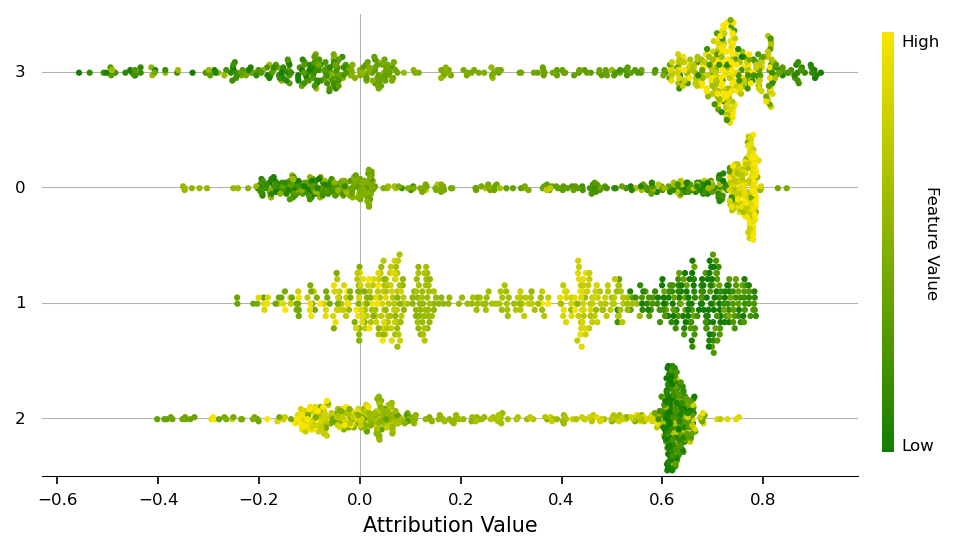

In [112]:
summary_plot(attributions=X,
             feature_values=data,
             feature_names=feat_name,
             plot_top_k=4)

Class 2


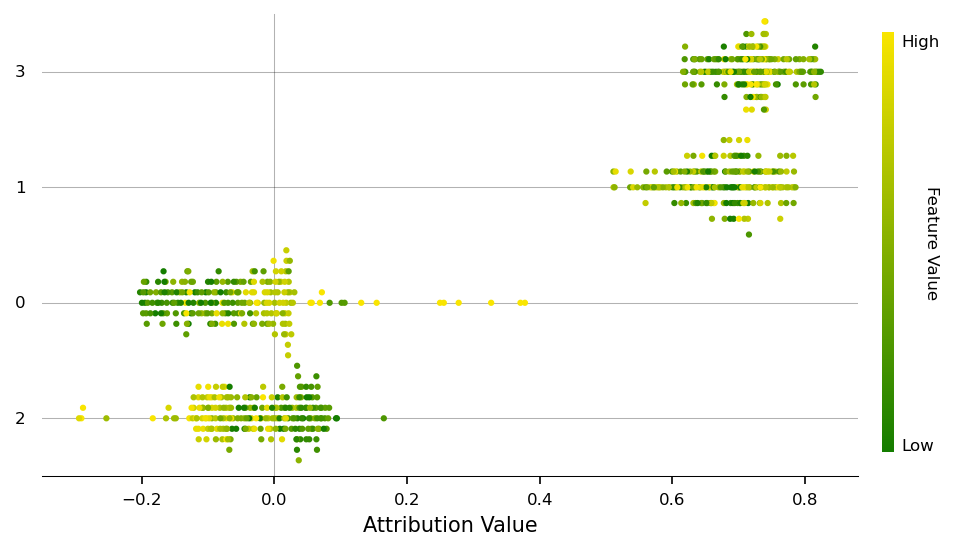

In [116]:
_class = 2
print(f"Class {_class}")
summary_plot(attributions=X[y==_class],
             feature_values=data[y==_class],
             feature_names=feat_name,
             plot_top_k=4)